In [12]:
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from data import get_dataset, get_zoo_elephants_images_and_labels, get_ELEP_images_and_labels
from tensorflow.keras import optimizers


In [1]:
!pwd

/Users/gandhalimarunmale/Documents/02_Sem/Computer Vision/cv-project/siamese


In [6]:
data_dir = '/Users/deepakduggirala/Documents/coco-dataset'

In [7]:
params = {
    'image_size': 256,
    'resize_pad': False,
    'dense_l2_reg_c': 0.0001,
    'embedding_size': 1,
    'lr': 0.001
}

cache_files = {
        'train': str(Path(data_dir) / 'train.cache'),
        'val': str(Path(data_dir) / 'val.cache')
}

## Images without resizepad

In [13]:
train_ds, N_train = get_dataset(get_zoo_elephants_images_and_labels, 
                                params, 
                                str(Path(data_dir)/'train'),
                                augment=True,  
                                cache_file=cache_files['train'], 
                                shuffle=True,
                                batch_size=32)

val_ds, N_val = get_dataset(get_zoo_elephants_images_and_labels, 
                            params, 
                            str(Path(data_dir)/'val'),
                            augment=False, 
                            cache_file=cache_files['val'], 
                            shuffle=False, 
                            batch_size=32)

train_ds = train_ds.map(lambda x, y: (x, tf.cast(y == b'elephants', tf.int32)),
        num_parallel_calls=tf.data.AUTOTUNE)

val_ds = val_ds.map(lambda x, y: (x, tf.cast(y == b'elephants', tf.int32)),
        num_parallel_calls=tf.data.AUTOTUNE)

### ResNet

In [14]:
base_model = tf.keras.applications.ResNet50V2(include_top=False, weights="imagenet", input_shape=(
        params['image_size'], params['image_size'], 3), pooling='avg')
base_model.trainable = False
inputs = tf.keras.Input(shape=(params['image_size'], params['image_size'], 3))
x = base_model(inputs, training=False)
embedding_layer = tf.keras.layers.Dense(
        units=params['embedding_size'],
        kernel_regularizer=tf.keras.regularizers.L2(params['dense_l2_reg_c']), 
        activation='sigmoid')(x)
model = tf.keras.Model(inputs, embedding_layer)

94683136/94668760 [==============================] - 14s 0us/step


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [16]:
model.compile(optimizer=optimizers.Adam(learning_rate=params['lr']), loss="binary_crossentropy", metrics=['accuracy'])

In [20]:
model.fit(train_ds, epochs=2, validation_data=val_ds)

NameError: name 'train_ds' is not defined

### Inception

In [9]:
base_model_inc = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_shape=(
        params['image_size'], params['image_size'], 3), pooling='avg')
base_model_inc.trainable = False
inputs = tf.keras.Input(shape=(params['image_size'], params['image_size'], 3))
x = base_model_inc(inputs, training=False)
embedding_layer = tf.keras.layers.Dense(
        units=params['embedding_size'],
        kernel_regularizer=tf.keras.regularizers.L2(params['dense_l2_reg_c']), 
        activation='sigmoid')(x)
model_inc = tf.keras.Model(inputs, embedding_layer)

In [10]:
model_inc.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [11]:
model_inc.compile(optimizer=optimizers.Adam(learning_rate=params['lr']), loss="binary_crossentropy", metrics=['accuracy'])

In [13]:
model_inc.fit(train_ds, epochs=2, validation_data=val_ds)

Epoch 1/2
135/135 [==============================] - 170s 1s/step - loss: 0.0741 - accuracy: 0.9815 - val_loss: 0.0243 - val_accuracy: 0.9958
Epoch 2/2
135/135 [==============================] - 170s 1s/step - loss: 0.0276 - accuracy: 0.9930 - val_loss: 0.0202 - val_accuracy: 0.9874


### Validation / metrics

In [41]:
image_paths, image_labels = get_zoo_elephants_images_and_labels(str(Path(data_dir)/'val'))

In [42]:
y_true = (np.array(image_labels) == 'elephants').astype(np.int32)

In [45]:
y_pred_proba = model.predict(val_ds)
y_pred_inc_proba = model_inc.predict(val_ds)

In [46]:
y_pred = (y_pred_proba > 0.5).astype(np.int32).flatten()
y_pred_inc_proba = (y_pred_inc_proba > 0.5).astype(np.int32).flatten()

In [47]:
np.mean(y_true == y_pred), np.mean(y_true == y_pred_inc_proba)

(0.9916317991631799, 0.9874476987447699)

In [48]:
np.sum(y_true != y_pred), np.sum(y_true != y_pred_inc_proba)

(2, 3)

(array([132.,   3.,   0.,   1.,   0.,   1.,   2.,   1.,   3.,  96.]),
 array([3.3836772e-05, 1.0002019e-01, 2.0000654e-01, 2.9999289e-01,
        3.9997923e-01, 4.9996561e-01, 5.9995192e-01, 6.9993830e-01,
        7.9992467e-01, 8.9991099e-01, 9.9989736e-01], dtype=float32),
 <BarContainer object of 10 artists>)

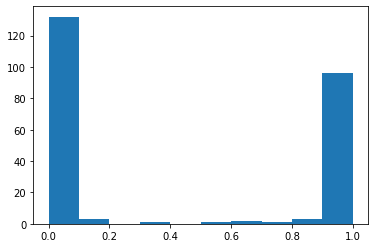

In [49]:
plt.hist(y_pred_proba)

(array([139.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 100.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

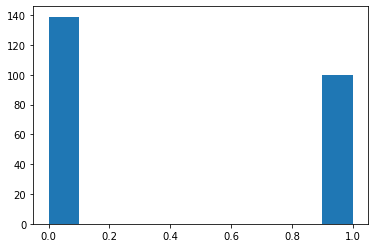

In [50]:
plt.hist(y_pred_inc_proba)

In [51]:
y_pred.shape

(239,)

In [52]:
mis_clf_idxs = np.where(y_true != y_pred)[0]
mis_clf_idxs_inc = np.where(y_true != y_pred_inc_proba)[0]

In [53]:
mis_clf_img_paths = np.array(image_paths)[np.where(y_true != y_pred)[0]]
mis_clf_img_paths_inc = np.array(image_paths)[np.where(y_true != y_pred_inc_proba)[0]]

(<matplotlib.image.AxesImage at 0x1699985b0>,
 '/Users/deepakduggirala/Documents/coco-dataset/val/others/114907_0.png')

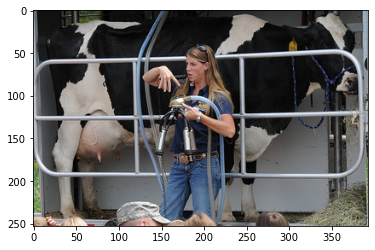

In [54]:
plt.imshow(plt.imread(mis_clf_img_paths[0])), mis_clf_img_paths[0]

('/Users/deepakduggirala/Documents/coco-dataset/val/others/14888_0.png',
 <matplotlib.image.AxesImage at 0x169a0f0d0>)

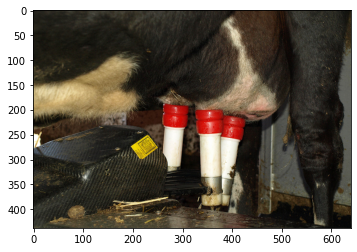

In [55]:
mis_clf_img_paths[1], plt.imshow(plt.imread(mis_clf_img_paths[1]))

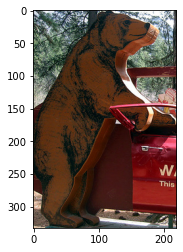

In [56]:
plt.imshow(plt.imread(mis_clf_img_paths_inc[0]))

(<matplotlib.image.AxesImage at 0x169adbfd0>,
 '/Users/deepakduggirala/Documents/coco-dataset/val/elephants/57027_1.png')

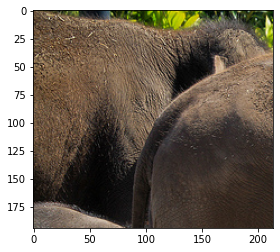

In [57]:
plt.imshow(plt.imread(mis_clf_img_paths_inc[1])), mis_clf_img_paths_inc[1]

(<matplotlib.image.AxesImage at 0x169b47d00>,
 '/Users/deepakduggirala/Documents/coco-dataset/val/elephants/166563_0.png')

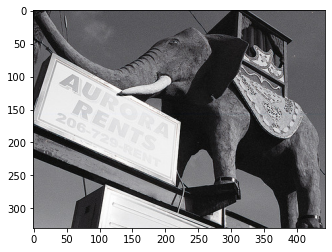

In [58]:
plt.imshow(plt.imread(mis_clf_img_paths_inc[2])), mis_clf_img_paths_inc[2]

### Embedding visualization

#### Train images without augmentation

In [22]:
train_ds, N_train = get_dataset(get_zoo_elephants_images_and_labels, 
                                params, 
                                str(Path(data_dir)/'train'),
                                augment=False,  
                                cache_file=None, 
                                shuffle=False,
                                batch_size=32)

In [23]:
image_paths, image_labels = get_zoo_elephants_images_and_labels(str(Path(data_dir)/'train'))
y_true = (np.array(image_labels) == 'elephants').astype(np.int32)

In [24]:
base_model = tf.keras.applications.ResNet50V2(include_top=False, weights="imagenet", input_shape=(
        params['image_size'], params['image_size'], 3), pooling='avg')
embeddings = base_model.predict(train_ds)

In [33]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(embeddings)

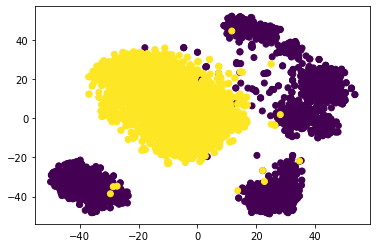

In [34]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_true)

In [27]:
base_model_inc = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_shape=(
        params['image_size'], params['image_size'], 3), pooling='avg')
embeddings_inc = base_model_inc.predict(train_ds)

In [31]:
from sklearn.manifold import TSNE
X_embedded_inc = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(embeddings_inc)

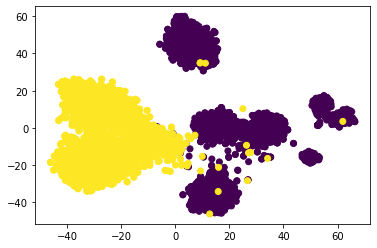

In [32]:
plt.scatter(X_embedded_inc[:,0], X_embedded_inc[:,1], c=y_true)

### Depthwise and 1x1 conv layers - ResNet

In [59]:
base_model2 = tf.keras.applications.ResNet50V2(include_top=False, weights="imagenet", input_shape=(
        params['image_size'], params['image_size'], 3))
base_model2.trainable = False
inputs = tf.keras.Input(shape=(params['image_size'], params['image_size'], 3))
x = base_model2(inputs, training=False)
conv1x1 = tf.keras.layers.Conv2D(kernel_size=1, filters=256, activation='relu')(x)
dw_conv = tf.keras.layers.DepthwiseConv2D(kernel_size=(8, 8))(conv1x1)
flatten = tf.keras.layers.Flatten()(dw_conv)
embedding_layer = tf.keras.layers.Dense(
        units=params['embedding_size'],
        kernel_regularizer=tf.keras.regularizers.L2(params['dense_l2_reg_c']), 
        activation='sigmoid')(flatten)
model_dw = tf.keras.Model(inputs, embedding_layer)

In [60]:
model_dw.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 conv2d_188 (Conv2D)         (None, 8, 8, 256)         524544    
                                                                 
 depthwise_conv2d (Depthwise  (None, 1, 1, 256)        16640     
 Conv2D)                                                         
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                           

In [61]:
model_dw.compile(
    optimizer=optimizers.Adam(learning_rate=params['lr']), 
    loss="binary_crossentropy", 
    metrics=['accuracy'])

In [64]:
model_dw.fit(train_ds, epochs=3, validation_data=val_ds)

Epoch 1/3
135/135 [==============================] - 212s 2s/step - loss: 0.0598 - accuracy: 0.9831 - val_loss: 0.0249 - val_accuracy: 0.9916
Epoch 2/3
135/135 [==============================] - 248s 2s/step - loss: 0.0119 - accuracy: 0.9961 - val_loss: 0.0230 - val_accuracy: 0.9916
Epoch 3/3
135/135 [==============================] - 233s 2s/step - loss: 0.0053 - accuracy: 0.9984 - val_loss: 0.0202 - val_accuracy: 0.9916


### Depthwise and 1x1 conv layers - Inception

In [66]:
base_model_inc2 = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_shape=(
        params['image_size'], params['image_size'], 3))
base_model_inc2.trainable = False
inputs = tf.keras.Input(shape=(params['image_size'], params['image_size'], 3))
x = base_model_inc2(inputs, training=False)
conv1x1 = tf.keras.layers.Conv2D(kernel_size=1, filters=256, activation='relu')(x)
dw_conv = tf.keras.layers.DepthwiseConv2D(kernel_size=(6, 6))(conv1x1)
flatten = tf.keras.layers.Flatten()(dw_conv)
embedding_layer = tf.keras.layers.Dense(
        units=params['embedding_size'],
        kernel_regularizer=tf.keras.regularizers.L2(params['dense_l2_reg_c']), 
        activation='sigmoid')(flatten)
model_inc_dw = tf.keras.Model(inputs, embedding_layer)

In [67]:
model_inc_dw.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 conv2d_378 (Conv2D)         (None, 6, 6, 256)         524544    
                                                                 
 depthwise_conv2d_2 (Depthwi  (None, 1, 1, 256)        9472      
 seConv2D)                                                       
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                           

In [68]:
model_inc_dw.compile(optimizer=optimizers.Adam(learning_rate=params['lr']), loss="binary_crossentropy", metrics=['accuracy'])

In [69]:
model_inc_dw.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
135/135 [==============================] - 190s 1s/step - loss: 0.0679 - accuracy: 0.9780 - val_loss: 0.0376 - val_accuracy: 0.9958
Epoch 2/5
135/135 [==============================] - 203s 1s/step - loss: 0.0152 - accuracy: 0.9949 - val_loss: 0.0390 - val_accuracy: 0.9916
Epoch 3/5


KeyboardInterrupt: 

## Images with resizepad

In [50]:
params = {
    'image_size': 256,
    'resize_pad': True,
    'dense_l2_reg_c': 0.0001,
    'embedding_size': 1,
    'lr': 0.001
}

cache_files = {
        'train': str(Path(data_dir) / 'train_resize.cache'),
        'val': str(Path(data_dir) / 'val_resize.cache')
}

In [51]:
train_ds, N_train = get_dataset(get_zoo_elephants_images_and_labels, 
                                params, 
                                str(Path(data_dir)/'train'),
                                augment=True,  
                                cache_file=cache_files['train'], 
                                shuffle=True,
                                batch_size=32)

val_ds, N_val = get_dataset(get_zoo_elephants_images_and_labels, 
                            params, 
                            str(Path(data_dir)/'val'),
                            augment=False, 
                            cache_file=cache_files['val'], 
                            shuffle=False, 
                            batch_size=32)

train_ds = train_ds.map(lambda x, y: (x, tf.cast(y == b'elephants', tf.int32)),
        num_parallel_calls=tf.data.AUTOTUNE)

val_ds = val_ds.map(lambda x, y: (x, tf.cast(y == b'elephants', tf.int32)),
        num_parallel_calls=tf.data.AUTOTUNE)